In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.2.0/spark-3.2.0-bin-hadoop3.2.tgz
!tar xf spark-3.2.0-bin-hadoop3.2.tgz
!pip install -q findspark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "spark-3.2.0-bin-hadoop3.2"

In [3]:
import findspark
findspark.init()

In [4]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
df = spark.read.csv("/content/drive/MyDrive/Colab Notebooks/Patient_Survival_Dataset.csv", header=True, inferSchema=True)

In [7]:
df = df.drop("_c83", "icu_id", "encounter_id", "patient_id", "hospital_id", "height", "weight", )

In [8]:
df = df.drop("gcs_unable_apache", "apache_4a_hospital_death_prob","apache_4a_icu_death_prob", "aids", "hepatic_failure", "leukemia", "lymphoma", "solid_tumor_with_metastasis")

In [ ]:
df.show()

In [14]:
from pyspark.sql.functions import isnan, when, count, col, round, desc

df.groupBy('gcs_unable_apache') \
  .agg(count('*').alias('count')) \
  .orderBy(desc('count')) \
  .show()

+-----------------+-----+
|gcs_unable_apache|count|
+-----------------+-----+
|                0|89812|
|             null| 1037|
|                1|  864|
+-----------------+-----+



In [ ]:
from pyspark.sql.functions import isnan, when, count, col, round
from pyspark.sql.types import StructType, StructField, StringType, FloatType


# Get the total number of rows in the DataFrame
total_rows = df.count()

# Calculate the percentage of null values in each column
null_percentages = []
for col_name in df.columns:
    null_count = df.filter(col(col_name).isNull()).count()
    null_percentage = ((null_count / total_rows) * 100)
    null_percentages.append(null_percentage)

# Create a new DataFrame with the percentage of null values for each column

schema = StructType([
    StructField("column_name", StringType(), True),
    StructField("null_percentage", FloatType(), True)
])

null_df = spark.createDataFrame(zip(df.columns, null_percentages), schema=schema)


In [ ]:
null_df.show(df.count())

+--------------------+---------------+
|         column_name|null_percentage|
+--------------------+---------------+
|                 age|      4.6100335|
|                 bmi|      3.7388375|
|    elective_surgery|            0.0|
|           ethnicity|      1.5210494|
|              gender|     0.02725895|
|    icu_admit_source|     0.12212009|
|       icu_stay_type|            0.0|
|            icu_type|            0.0|
|    pre_icu_los_days|            0.0|
|  apache_2_diagnosis|      1.8121749|
| apache_3j_diagnosis|      1.2004842|
|apache_post_opera...|            0.0|
|          arf_apache|      0.7796059|
|     gcs_eyes_apache|      2.0727706|
|    gcs_motor_apache|      2.0727706|
|   gcs_verbal_apache|      2.0727706|
|   heart_rate_apache|      0.9573343|
|    intubated_apache|      0.7796059|
|          map_apache|      1.0838158|
|     resprate_apache|      1.3455018|
|         temp_apache|      4.4791903|
|   ventilated_apache|      0.7796059|
|       d1_diasbp_max|   

In [18]:
df.count()

91713

# Dropping All Null Rows

In [10]:
df1 = df.dropna()

In [11]:
df1.count()

61955

# Mapping the Qualitative Variables

In [20]:
from pyspark.sql.functions import count, desc, when


Ethnicity

In [21]:
df1.groupBy('ethnicity') \
  .agg(count('*').alias('count')) \
  .orderBy(desc('count')) \
  .show()

+----------------+-----+
|       ethnicity|count|
+----------------+-----+
|       Caucasian|48245|
|African American| 6586|
|   Other/Unknown| 3223|
|        Hispanic| 2560|
|           Asian|  714|
| Native American|  627|
+----------------+-----+



In [22]:
df1 = df1.withColumn("ethnicity", 
                   when(df1["ethnicity"] == "Caucasian", 1)
                   .when(df1["ethnicity"] == "African American", 2)
                   .when(df1["ethnicity"] == "Other/Unknown", 3)
                   .when(df1["ethnicity"] == "Hispanic", 4)
                   .when(df1["ethnicity"] == "Asian", 5)
                   .when(df1["ethnicity"] == "Native American", 6)
                   .otherwise(df1["ethnicity"]))

In [23]:
df1.groupBy('ethnicity') \
  .agg(count('*').alias('count')) \
  .orderBy(desc('count')) \
  .show()

+---------+-----+
|ethnicity|count|
+---------+-----+
|        1|48245|
|        2| 6586|
|        3| 3223|
|        4| 2560|
|        5|  714|
|        6|  627|
+---------+-----+



Gender

In [24]:
df1.groupBy('gender') \
  .agg(count('*').alias('count')) \
  .orderBy(desc('count')) \
  .show()

+------+-----+
|gender|count|
+------+-----+
|     M|33652|
|     F|28303|
+------+-----+



In [25]:
df1 = df1.withColumn("gender", 
                   when(df1["gender"] == "M", 1)
                   .when(df1["gender"] == "F", 2)
                   .otherwise(df1["gender"]))

In [26]:
df1.groupBy('gender') \
  .agg(count('*').alias('count')) \
  .orderBy(desc('count')) \
  .show()

+------+-----+
|gender|count|
+------+-----+
|     1|33652|
|     2|28303|
+------+-----+



ICU Admit Source

In [27]:
df1.groupBy('icu_admit_source') \
  .agg(count('*').alias('count')) \
  .orderBy(desc('count')) \
  .show()

+--------------------+-----+
|    icu_admit_source|count|
+--------------------+-----+
|Accident & Emergency|37746|
|Operating Room / ...|11085|
|               Floor|10905|
|      Other Hospital| 1808|
|           Other ICU|  411|
+--------------------+-----+



In [28]:
df1 = df1.withColumn("icu_admit_source", 
                   when(df1["icu_admit_source"] == "Accident & Emergency", 1)
                   .when(df1["icu_admit_source"] == "Operating Room / Recovery", 2)
                   .when(df1["icu_admit_source"] == "Floor", 3)
                   .when(df1["icu_admit_source"] == "Other Hospital", 4)
                   .when(df1["icu_admit_source"] == "Other ICU", 5)
                   .otherwise(df1["icu_admit_source"]))

In [29]:
df1.groupBy('icu_admit_source') \
  .agg(count('*').alias('count')) \
  .orderBy(desc('count')) \
  .show()

+----------------+-----+
|icu_admit_source|count|
+----------------+-----+
|               1|37746|
|               2|11085|
|               3|10905|
|               4| 1808|
|               5|  411|
+----------------+-----+



ICU Stay Type

In [30]:
df1.groupBy('icu_stay_type') \
  .agg(count('*').alias('count')) \
  .orderBy(desc('count')) \
  .show()

+-------------+-----+
|icu_stay_type|count|
+-------------+-----+
|        admit|57915|
|     transfer| 3794|
|      readmit|  246|
+-------------+-----+



In [31]:
df1 = df1.withColumn("icu_stay_type", 
                   when(df1["icu_stay_type"] == "admit", 1)
                   .when(df1["icu_stay_type"] == "transfer", 2)
                   .when(df1["icu_stay_type"] == "readmit", 3)
                   .otherwise(df1["icu_stay_type"]))

In [32]:
df1.groupBy('icu_stay_type') \
  .agg(count('*').alias('count')) \
  .orderBy(desc('count')) \
  .show()

+-------------+-----+
|icu_stay_type|count|
+-------------+-----+
|            1|57915|
|            2| 3794|
|            3|  246|
+-------------+-----+



ICU Type

In [33]:
df1.groupBy('icu_type') \
  .agg(count('*').alias('count')) \
  .orderBy(desc('count')) \
  .show()

+------------+-----+
|    icu_type|count|
+------------+-----+
|Med-Surg ICU|33826|
|        MICU| 6059|
|   Neuro ICU| 5260|
|   CCU-CTICU| 4666|
|        SICU| 3921|
| Cardiac ICU| 3267|
|       CSICU| 3176|
|       CTICU| 1780|
+------------+-----+



In [34]:
df1 = df1.withColumn("icu_type", 
                   when(df1["icu_type"] == "Med-Surg ICU", 1)
                   .when(df1["icu_type"] == "MICU", 2)
                   .when(df1["icu_type"] == "Neuro ICU", 3)
                   .when(df1["icu_type"] == "CCU-CTICU", 4)
                   .when(df1["icu_type"] == "SICU", 5)
                   .when(df1["icu_type"] == "Cardiac ICU", 6)
                   .when(df1["icu_type"] == "CSICU", 7)
                   .when(df1["icu_type"] == "CTICU", 8)
                   .otherwise(df1["icu_type"]))

In [35]:
df1.groupBy('icu_type') \
  .agg(count('*').alias('count')) \
  .orderBy(desc('count')) \
  .show()

+--------+-----+
|icu_type|count|
+--------+-----+
|       1|33826|
|       2| 6059|
|       3| 5260|
|       4| 4666|
|       5| 3921|
|       6| 3267|
|       7| 3176|
|       8| 1780|
+--------+-----+



Apache_3j_bodysystem

In [36]:
df1.groupBy('apache_3j_bodysystem') \
  .agg(count('*').alias('count')) \
  .orderBy(desc('count')) \
  .show()

+--------------------+-----+
|apache_3j_bodysystem|count|
+--------------------+-----+
|      Cardiovascular|18684|
|              Sepsis| 9022|
|         Respiratory| 8303|
|        Neurological| 8112|
|    Gastrointestinal| 6473|
|           Metabolic| 5662|
|              Trauma| 2677|
|       Genitourinary| 1593|
|Musculoskeletal/Skin|  766|
|       Hematological|  455|
|       Gynecological|  208|
+--------------------+-----+



In [37]:
df1 = df1.withColumn("apache_3j_bodysystem", 
                   when(df1["apache_3j_bodysystem"] == "Cardiovascular", 1)
                   .when(df1["apache_3j_bodysystem"] == "Sepsis", 2)
                   .when(df1["apache_3j_bodysystem"] == "Respiratory", 3)
                   .when(df1["apache_3j_bodysystem"] == "Neurological", 4)
                   .when(df1["apache_3j_bodysystem"] == "Gastrointestinal", 5)
                   .when(df1["apache_3j_bodysystem"] == "Metabolic", 6)
                   .when(df1["apache_3j_bodysystem"] == "Trauma", 7)
                   .when(df1["apache_3j_bodysystem"] == "Genitourinary", 8)
                   .when(df1["apache_3j_bodysystem"] == "Musculoskeletal/Skin", 9)
                   .when(df1["apache_3j_bodysystem"] == "Hematological", 10)
                   .when(df1["apache_3j_bodysystem"] == "Gynecological", 11)
                   .otherwise(df1["apache_3j_bodysystem"]))

In [38]:
df1.groupBy('apache_3j_bodysystem') \
  .agg(count('*').alias('count')) \
  .orderBy(desc('count')) \
  .show()

+--------------------+-----+
|apache_3j_bodysystem|count|
+--------------------+-----+
|                   1|18684|
|                   2| 9022|
|                   3| 8303|
|                   4| 8112|
|                   5| 6473|
|                   6| 5662|
|                   7| 2677|
|                   8| 1593|
|                   9|  766|
|                  10|  455|
|                  11|  208|
+--------------------+-----+



apache_2_bodysystem

In [39]:
# Replace "Undefined diagnoses" with "Undefined Diagnoses" in the "apache_2_bodysystem" column
df1 = df1.withColumn("apache_2_bodysystem", when(df1.apache_2_bodysystem == "Undefined diagnoses", "Undefined Diagnoses").otherwise(df1.apache_2_bodysystem))

In [40]:
df1.groupBy('apache_2_bodysystem') \
  .agg(count('*').alias('count')) \
  .orderBy(desc('count')) \
  .show()

+-------------------+-----+
|apache_2_bodysystem|count|
+-------------------+-----+
|     Cardiovascular|26161|
|        Respiratory| 8303|
|         Neurologic| 8112|
|   Gastrointestinal| 6473|
|          Metabolic| 5662|
|             Trauma| 2677|
|Undefined Diagnoses| 2323|
|Renal/Genitourinary| 1789|
|       Haematologic|  455|
+-------------------+-----+



In [41]:
df1 = df1.withColumn("apache_2_bodysystem", 
                   when(df1["apache_2_bodysystem"] == "Cardiovascular", 1)
                   .when(df1["apache_2_bodysystem"] == "Respiratory", 2)
                   .when(df1["apache_2_bodysystem"] == "Neurologic", 3)
                   .when(df1["apache_2_bodysystem"] == "Gastrointestinal", 4)
                   .when(df1["apache_2_bodysystem"] == "Metabolic", 5)
                   .when(df1["apache_2_bodysystem"] == "Undefined Diagnoses", 6)
                   .when(df1["apache_2_bodysystem"] == "Trauma", 7)
                   .when(df1["apache_2_bodysystem"] == "Renal/Genitourinary", 8)
                   .when(df1["apache_2_bodysystem"] == "Haematologic", 9)
                   .otherwise(df1["apache_2_bodysystem"]))

In [42]:
df1.groupBy('apache_2_bodysystem') \
  .agg(count('*').alias('count')) \
  .orderBy(desc('count')) \
  .show()

+-------------------+-----+
|apache_2_bodysystem|count|
+-------------------+-----+
|                  1|26161|
|                  2| 8303|
|                  3| 8112|
|                  4| 6473|
|                  5| 5662|
|                  7| 2677|
|                  6| 2323|
|                  8| 1789|
|                  9|  455|
+-------------------+-----+



# Changing the data type of the recently mapped qualitative variables

In [43]:
from pyspark.sql.functions import isnan, when, count, col, round


In [44]:
df1 = df1.withColumn("icu_admit_source", col("icu_admit_source").cast("integer"))
df1 = df1.withColumn("icu_stay_type", col("icu_stay_type").cast("integer"))
df1 = df1.withColumn("icu_type", col("icu_type").cast("integer"))
df1 = df1.withColumn("apache_3j_bodysystem", col("apache_3j_bodysystem").cast("integer"))
df1 = df1.withColumn("apache_2_bodysystem", col("apache_2_bodysystem").cast("integer"))
df1 = df1.withColumn("gender", col("gender").cast("integer"))
df1 = df1.withColumn("ethnicity", col("ethnicity").cast("integer"))



In [45]:
df1.printSchema()


root
 |-- age: integer (nullable = true)
 |-- bmi: double (nullable = true)
 |-- elective_surgery: integer (nullable = true)
 |-- ethnicity: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- icu_admit_source: integer (nullable = true)
 |-- icu_stay_type: integer (nullable = true)
 |-- icu_type: integer (nullable = true)
 |-- pre_icu_los_days: double (nullable = true)
 |-- apache_2_diagnosis: integer (nullable = true)
 |-- apache_3j_diagnosis: double (nullable = true)
 |-- apache_post_operative: integer (nullable = true)
 |-- arf_apache: integer (nullable = true)
 |-- gcs_eyes_apache: integer (nullable = true)
 |-- gcs_motor_apache: integer (nullable = true)
 |-- gcs_verbal_apache: integer (nullable = true)
 |-- heart_rate_apache: integer (nullable = true)
 |-- intubated_apache: integer (nullable = true)
 |-- map_apache: integer (nullable = true)
 |-- resprate_apache: double (nullable = true)
 |-- temp_apache: double (nullable = true)
 |-- ventilated_apache: integer 

In [46]:
df1.show()

+---+-----------+----------------+---------+------+----------------+-------------+--------+----------------+------------------+-------------------+---------------------+----------+---------------+----------------+-----------------+-----------------+----------------+----------+---------------+-----------+-----------------+-------------+-------------+-------------------------+-------------------------+----------------+----------------+----------+----------+----------------------+----------------------+---------------+---------------+-----------+-----------+------------+------------+------------------------+------------------------+-----------+-----------+-------------+-------------+-------------------------+-------------------------+----------------+----------------+----------+----------+----------------------+----------------------+---------------+---------------+-----------+-----------+------------+------------+------------------------+------------------------+--------------+----------

# Performing Pearson Correlation Test

In [47]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# Assuming `df1` is your input DataFrame containing columns
assembler = VectorAssembler(inputCols=[c for c in df1.columns], outputCol="features")
data = assembler.transform(df1).select("features")

# Compute the correlation matrix using Pearson correlation
corr_matrix = Correlation.corr(data, "features", "pearson").head()[0]

# Convert the correlation matrix to a PySpark DataFrame
corr_df = spark.createDataFrame(corr_matrix.toArray().tolist(), [c for c in df1.columns])


/content/spark-3.2.0-bin-hadoop3.2/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


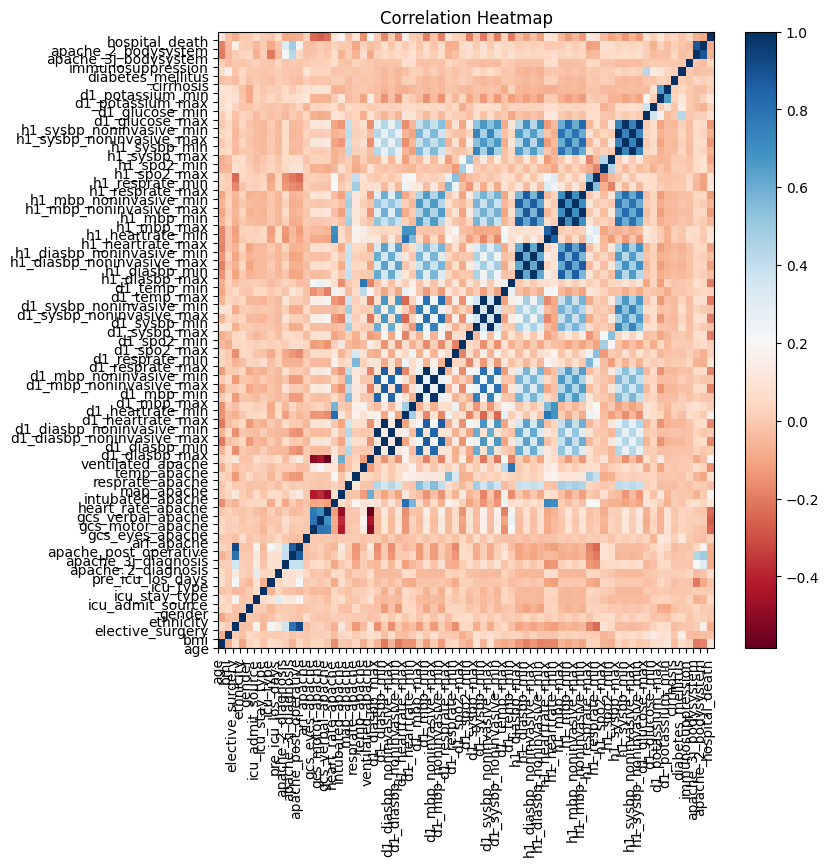

In [48]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert the PySpark DataFrame to a Pandas DataFrame
corr_pdf = corr_df.toPandas()

# Create a correlation heatmap using the Pandas corr() and heatmap() functions
plt.figure(figsize=(8,8))
heatmap = plt.pcolor(corr_pdf, cmap='RdBu')
plt.colorbar(heatmap)
plt.xticks(range(len(corr_pdf.columns)), corr_pdf.columns, rotation=90)
plt.yticks(range(len(corr_pdf.columns)), corr_pdf.columns)
plt.title('Correlation Heatmap')
plt.show()


In [ ]:
corr_df.show(corr_df.count())

In [ ]:
from pyspark.sql.functions import desc

# Select the last column of corr_df and transform it into a list
corr_list = corr_df.select(corr_df.columns[-1]).rdd.flatMap(lambda x: x).collect()

# Zip the column names with the correlation values
zipped = zip(df1.columns, corr_list)

# Create a new dataframe from the zipped list
new_df = spark.createDataFrame(zipped, ["Variable", "Correlation with hospital_death"])

# Sort the new dataframe in descending order based on correlation values
new_df = new_df.orderBy(desc("Correlation with hospital_death"))

# Show the new dataframe
new_df.show(new_df.count(), truncate=False)


# Random Forest to check Important Scores of the features

In [50]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Assuming you have a PySpark DataFrame 'df' with columns 'feature1', 'feature2', ..., 'featureN' and 'hospital_death'
# Assemble the features into a single vector column 'features'

input_cols = [c for c in df1.columns if c != 'hospital_death']

assembler = VectorAssembler(inputCols= input_cols, outputCol='features')
data = assembler.transform(df1)


# Train a Random Forest model with a large number of trees and random feature selection

rf = RandomForestClassifier(labelCol='hospital_death', featuresCol='features', numTrees=100, featureSubsetStrategy='sqrt')
model = rf.fit(data)




In [51]:
# Evaluate the model on the training set

evaluator = BinaryClassificationEvaluator(labelCol='hospital_death')
predictions = model.transform(data)
auc = evaluator.evaluate(predictions)
print("AUC on the whole data: {:.3f}".format(auc))


AUC on the whole data: 0.821


In [ ]:
# Extract the feature importances from the trained model
importances = model.featureImportances

# Print the feature importances in descending order with their names
print("Feature Importances:")
for i in range(len(importances)):
    print("Feature {}: {}: {}".format(i+1, input_cols[i], importances[i]))

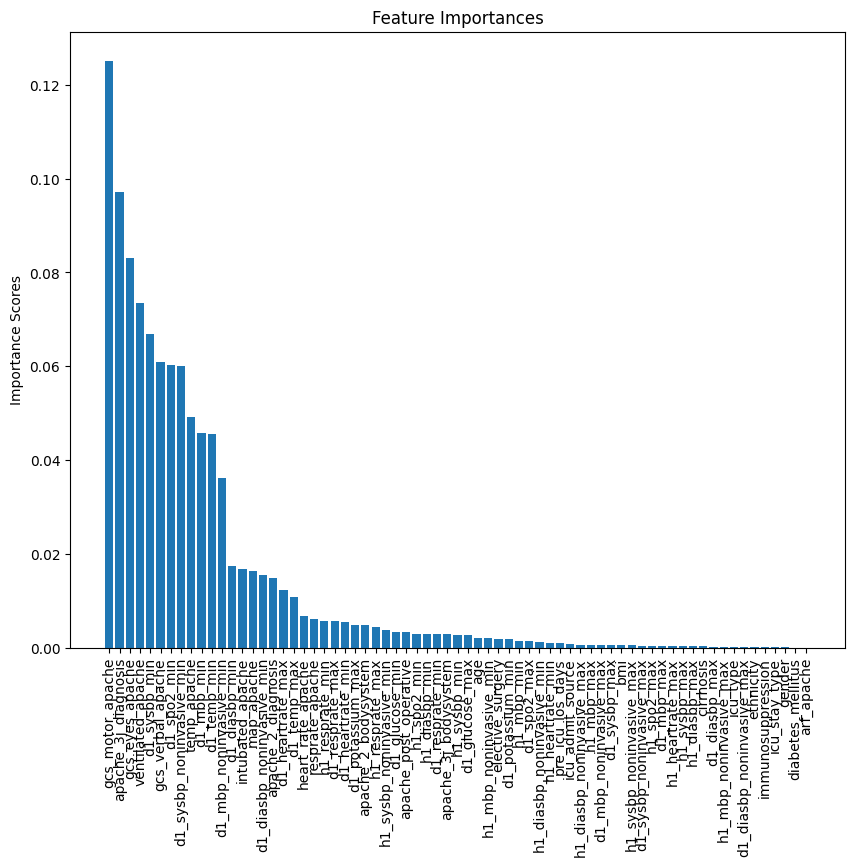

In [57]:
# Sort the feature importances in descending order
sorted_importances = sorted(zip(importances, input_cols), reverse=True)

# Create a bar plot of the feature importances
plt.figure(figsize=(10, 8))
plt.bar([x[1] for x in sorted_importances], [x[0] for x in sorted_importances])
plt.xticks(rotation=90)
plt.ylabel("Importance Scores")
plt.title("Feature Importances")
plt.show()

# Based on Correlation and Importance scores, we have selected important health indicators. We have also selected a few qualitative features which we believe may help us to make more accurate prediction. 

Final Dataset:

In [12]:
df2 = df.select('age','bmi','gender', 'icu_admit_source', 'icu_type', 'ventilated_apache', 'intubated_apache', 'd1_heartrate_max', 'h1_resprate_max', 'heart_rate_apache', 'd1_resprate_max', 'h1_heartrate_max', 'd1_potassium_max', 'h1_resprate_min', 'h1_spo2_min', 'h1_diasbp_min', 'h1_mbp_min', 'h1_mbp_noninvasive_min', 'h1_sysbp_noninvasive_min', 'h1_sysbp_min','d1_diasbp_noninvasive_min', 'd1_diasbp_min', 'd1_mbp_noninvasive_min', 'd1_mbp_min', 'd1_spo2_min', 'd1_temp_min', 'd1_sysbp_noninvasive_min', 'd1_sysbp_min', 'gcs_verbal_apache', 'gcs_eyes_apache', 'gcs_motor_apache', 'apache_3j_bodysystem', 'apache_2_bodysystem', 'hospital_death')

ventilated_apache| 0.22678002251287382|
|    intubated_apache|  0.1897125325577809|
|    d1_heartrate_max|  0.1586539272084231|
|     h1_resprate_max| 0.11762600132693751|
|   heart_rate_apache| 0.11054394108391259|
|     d1_resprate_max| 0.10782131226955967|
|    h1_heartrate_max| 0.10718981844605156|
|                 age| 0.10605493441560195|
|    d1_potassium_max| 0.10472109648072363|
|     h1_resprate_min| 0.09958531762182729|

h1_spo2_min|-0.10584043969074303|
|       h1_diasbp_min|-0.11743027438580324|
|          h1_mbp_min|-0.12989236688246783|
|h1_mbp_noninvasiv...|-0.13019126863203898|
|h1_sysbp_noninvas...|-0.13315276797607709|
|        h1_sysbp_min|-0.13359000444798702|
|d1_diasbp_noninva...|-0.17053138051948635|
|       d1_diasbp_min|-0.17063957741857422|
|d1_mbp_noninvasiv...|-0.18610608187230018|
|          d1_mbp_min|-0.18638333403729485|
|         d1_spo2_min|-0.19672903264365865|
|         d1_temp_min|-0.19983432350006064|
|d1_sysbp_noninvas...|-0.19984031801579932|
|        d1_sysbp_min|-0.19996418373653765|
|   gcs_verbal_apache|-0.23164879955867115|
|     gcs_eyes_apache|-0.24729030349988793|
|    gcs_motor_apache|

In [ ]:
len(df2.columns)

34

In [ ]:
df.count()

91713

In [ ]:
df2.count()

91713

In [ ]:
df2 = df2.dropna()

In [ ]:
df2.count()

63536

In [ ]:
df2.show()

+---+-----------+------+--------------------+------------+-----------------+----------------+----------------+---------------+-----------------+---------------+----------------+----------------+---------------+-----------+-------------+----------+----------------------+------------------------+------------+-------------------------+-------------+----------------------+----------+-----------+-----------+------------------------+------------+-----------------+---------------+----------------+--------------------+-------------------+--------------+
|age|        bmi|gender|    icu_admit_source|    icu_type|ventilated_apache|intubated_apache|d1_heartrate_max|h1_resprate_max|heart_rate_apache|d1_resprate_max|h1_heartrate_max|d1_potassium_max|h1_resprate_min|h1_spo2_min|h1_diasbp_min|h1_mbp_min|h1_mbp_noninvasive_min|h1_sysbp_noninvasive_min|h1_sysbp_min|d1_diasbp_noninvasive_min|d1_diasbp_min|d1_mbp_noninvasive_min|d1_mbp_min|d1_spo2_min|d1_temp_min|d1_sysbp_noninvasive_min|d1_sysbp_min|gcs_

In [59]:
df2.columns

['age',
 'bmi',
 'gender',
 'icu_admit_source',
 'icu_type',
 'ventilated_apache',
 'intubated_apache',
 'd1_heartrate_max',
 'h1_resprate_max',
 'heart_rate_apache',
 'd1_resprate_max',
 'h1_heartrate_max',
 'd1_potassium_max',
 'h1_resprate_min',
 'h1_spo2_min',
 'h1_diasbp_min',
 'h1_mbp_min',
 'h1_mbp_noninvasive_min',
 'h1_sysbp_noninvasive_min',
 'h1_sysbp_min',
 'd1_diasbp_noninvasive_min',
 'd1_diasbp_min',
 'd1_mbp_noninvasive_min',
 'd1_mbp_min',
 'd1_spo2_min',
 'd1_temp_min',
 'd1_sysbp_noninvasive_min',
 'd1_sysbp_min',
 'gcs_verbal_apache',
 'gcs_eyes_apache',
 'gcs_motor_apache',
 'apache_3j_bodysystem',
 'apache_2_bodysystem',
 'hospital_death']

In [16]:
df_num = df2.select('gender', 'apache_2_bodysystem','apache_3j_bodysystem', 'icu_admit_source', 'icu_type')

In [17]:
print("7 Categorical Features")
df_num.columns

7 Categorical Features


['gender',
 'apache_2_bodysystem',
 'apache_3j_bodysystem',
 'icu_admit_source',
 'icu_type']

26 -  Numerical Health Indicators
7 - Categorical Health Info
1 - Predictor

# Creating CSV file of final dataset

In [ ]:
df2.coalesce(1).write.format("csv").option("header", "true").save("/content/drive/MyDrive/Colab Notebooks/Patient_Survival_Final_Dataset.csv")


Reading the saved csv from google drive

In [6]:
df3 = spark.read.csv("/content/drive/MyDrive/Patient_Survival_Final_Dataset.csv",header=True, inferSchema=True)

In [9]:
len(df3.columns)

34

In [10]:
df_num = df3.drop('gender', 'apache_2_bodysystem','apache_3j_bodysystem', 'icu_admit_source', 'icu_type', 'hospital_death')

In [11]:
print("28 Numerical Features")
df_num.columns

28 Numerical Features


['age',
 'bmi',
 'ventilated_apache',
 'intubated_apache',
 'd1_heartrate_max',
 'h1_resprate_max',
 'heart_rate_apache',
 'd1_resprate_max',
 'h1_heartrate_max',
 'd1_potassium_max',
 'h1_resprate_min',
 'h1_spo2_min',
 'h1_diasbp_min',
 'h1_mbp_min',
 'h1_mbp_noninvasive_min',
 'h1_sysbp_noninvasive_min',
 'h1_sysbp_min',
 'd1_diasbp_noninvasive_min',
 'd1_diasbp_min',
 'd1_mbp_noninvasive_min',
 'd1_mbp_min',
 'd1_spo2_min',
 'd1_temp_min',
 'd1_sysbp_noninvasive_min',
 'd1_sysbp_min',
 'gcs_verbal_apache',
 'gcs_eyes_apache',
 'gcs_motor_apache']